# Summary
It's my first time doing such an extensive EDA, so apologies for many things being sloppier and messier than they ought to be - I didn't expect to reuse so much code for one, so more helper functions would definitely have been helpful. A more consistent naming scheme would also have made things clearer and less confusing for myself.

I must also declare from the start that a lot of the code in this notebook was generated with GitHub Copilot. However, it only helped me with the implementation of the code, and not with the steps I wanted to take. The methods explored in this notebook are from my own self-reading and thinking.

## Categorical Data
For the categorical data, I explored the chi-squared test and the mutual information gain test to prune features. However, the features pruned caused the models to perform slightly worse (if only marginally), and this dataset is quite small, so I ended up keeping all features.

I tried a variety of models, starting with Linear Regression as I thought the target variable was closer to ordinal in nature. However, Linear Regression performed quite poorly. Models which predicted a categorical target variable performed much better instead, such as Gradient Boosting and Logistic Regression

## Text Data
For the text data, first cleaned up the text, then tried running it through a LGTM Neural Network and Convolutional Neural Network respectively. The CNN performed slightly better, and I'm quite happy with its performance given it is predicting in isolation of other features, and despite still containing some unfamiliar words after the processing (for example, some descriptions were in Malay.)

I then tried using a LLM(gpt-3.5-turbo) to generate predictions. Though not as good as the neural networks, it performed slgihtly above my expectations. I think it may have been possible to push it to perform better through fine-tuning, or use it as a way to generate new features, but I couldn't explore this due to time constraints (looming exams 😭). This is an area that I'm very interested to explore in the future though.

Unfortunately, I was also unable to integrate the predictions of the two models, and they both performed better individually despite my exploration of using the CNN predictions as a variable, or to find the average of the two predictions. 

## The final model
In the final model, I plan to generate two predictions - the speed of the pet being adopted based on the categorical/quantitative data, and the speed of the pet being adopted based on the text data. I believe they can be used in two ways - the first one can be used to recommend pets which are more likely to be popular for adopters, as well as identify pets which may have a problem being adopted so they too can be pushed more often for adopters to consider. The second prediction acts more like a grade for the description, where a poor prediction might mean that the description can be written in a better/more appealing manner.

In [100]:
# Load the dataset
import pandas as pd
import numpy as np

df = pd.read_csv('pets_prepared.csv')
df.head()

,PetID,AdoptionSpeed,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,HealthName,VaccinatedName,DewormedName,SterilizedName,BreedName,BreedBinsName,StateName,StateBinsName,ColorName,AdoptedName
0,86e1089a3,2,2,Nibble,3,299,0,1,1,7,...,Healthy,No,No,No,Tabby,Tabby,Selangor,Selangor,Black,Y
1,6296e909a,0,2,No Name Yet,1,265,0,1,1,2,...,Healthy,Not Sure,Not Sure,Not Sure,Domestic Medium Hair,Domestic Medium Hair,Kuala Lumpur,Kuala Lumpur,Black,Y
2,3422e4906,3,1,Brisco,1,307,0,1,2,7,...,Healthy,Yes,Yes,No,Mixed Breed,Mixed Breed,Selangor,Selangor,Brown,Y
3,5842f1ff5,2,1,Miko,4,307,0,2,1,2,...,Healthy,Yes,Yes,No,Mixed Breed,Mixed Breed,Kuala Lumpur,Kuala Lumpur,Black,Y
4,850a43f90,2,1,Hunter,1,307,0,1,1,0,...,Healthy,No,No,No,Mixed Breed,Mixed Breed,Selangor,Selangor,Black,Y


In [58]:
# Check dimensions of data
df.shape

(14993, 49)

In [178]:
# Check distribution of target variable
df['AdoptionSpeed'].value_counts()

AdoptionSpeed
4    4197
2    4037
3    3259
1    3090
0     410
Name: count, dtype: int64

In [59]:
# Investigate the nature of data in the AgeBins column, which seems less intuitive to me
df['AgeBins'].value_counts()

AgeBins
[  3,  6)    3670
2            3503
[  0,  2)    2483
[ 24, 60)    1601
[  6, 12)    1588
[ 12, 24)    1557
[ 60,255]     591
Name: count, dtype: int64

In [60]:
mask = df['AgeBins'] == '2'
print(df.loc[mask, 'Age'].value_counts())
all_age_2 = (df.loc[mask, 'Age'] == 2).all()

print(all_age_2)

# Seems strange there are so many pets in the '2' category, but they are not wrongly classified
# Later, I learnt that many pets are only put up for adoption when they are 2 months old,
# when they are more ready!

Age
2    3503
Name: count, dtype: int64
True


In [61]:
df['BreedBins'].value_counts()

BreedBins
307       5927
266       3634
Others    3272
265       1258
299        342
264        296
292        264
Name: count, dtype: int64

In [62]:
df[['BreedBins', 'BreedName']].head(50)

# 307 corresponds with Mixed Breed
# All the less common breeds are grouped together in the 'Other' category
# We may want to encode the less common breeds as well depending on the entropy of the column

,BreedBins,BreedName
0,299,Tabby
1,265,Domestic Medium Hair
2,307,Mixed Breed
3,307,Mixed Breed
4,307,Mixed Breed
5,266,Domestic Short Hair
6,264,Domestic Long Hair
7,307,Mixed Breed
8,265,Domestic Medium Hair
9,265,Domestic Medium Hair


In [63]:
# Investigate the frequency of the "Breed1" column
df['Breed1'].value_counts()

Breed1
307    5927
266    3634
265    1258
299     342
264     296
       ... 
176       1
214       1
125       1
123       1
81        1
Name: count, Length: 176, dtype: int64

In [64]:
# Investigate the frequency of the "Breed2" column
df['Breed2'].value_counts()

Breed2
0      10762
307     1727
266      599
265      321
299      138
       ...  
104        1
36         1
17         1
257        1
279        1
Name: count, Length: 135, dtype: int64

In [65]:
# The number of unique values in the "Breed1" and "Breed2" columns is quite high. 
# I suspect that Breed can be encompassed by FurLength and BreedPure since majority of pets 
# are mixed breed or domestic

In [66]:
def process_df(df):
    y = df['AdoptionSpeed']

    # Column 32 onwards are all derived values or labels which have already been encoded
    # We will keep BreedPure, ColorAmt and NameorNO though because the information may be lost when we remove the original columns
    x = df.iloc[:,:34].drop('AdoptionSpeed', axis=1)

    # We may deal with these columns later, they are difficult to encode/likely not useful for analysis
    x = x.drop(['PetID', 'Name', 'Description', 'RescuerID'], axis=1)

    # Remove numerical columns because they have been binned
    x = x.drop(['Breed1', 'Breed2', 'Age', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt'], axis=1)
    return x, y

x, y = process_df(df)

# Find columns with missing values
x.isnull().sum()

# No missing values!

Type            0
Gender          0
Color1          0
Color2          0
Color3          0
MaturitySize    0
FurLength       0
Vaccinated      0
Dewormed        0
Sterilized      0
Health          0
AgeBins         0
FeeBins         0
BreedBins       0
StateBins       0
VideoAmtBins    0
PhotoAmtBins    0
QuantityBins    0
BreedPure       0
ColorAmt        0
NameorNO        0
dtype: int64

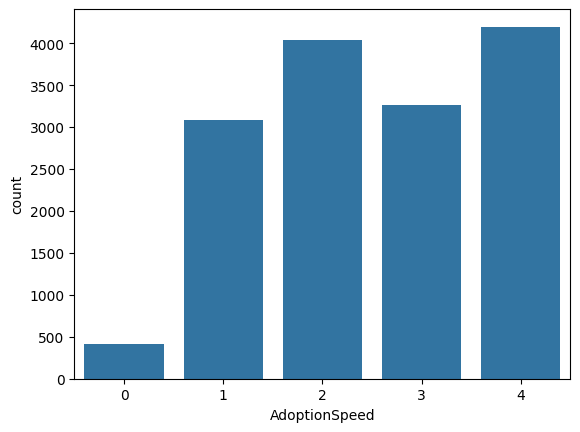

In [67]:
# Visualise distribution of the target AdoptionSpeed variable
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=y.value_counts().index, y=y.value_counts())
plt.show()

In [ ]:
# Visualise each column against the target AdoptionSpeed variable
from statsmodels.graphics.mosaicplot import mosaic


'''
for column in x.columns:
    # Sort the DataFrame
    df_sorted = df.sort_values(by=['AdoptionSpeed', column])
    mosaic(df_sorted, [column, 'AdoptionSpeed'], title=column)
'''

# Commenting this cell out because it takes some time to run and output clutters the screen
# Uncomment to view the mosaic plots

In [ ]:
# Focusing on the FeeBins plot, initially I wanted to make a variable 
# determining how "expensive" the pet is relatively to other pets of similar breed and age
# However, the plot shows that a large proportion of pets are free, so there may be insufficient
# data to make a meaningful comparison

# Furthermore, considering the ethical requirements of the project, it may be inappropriate to
# make a variable that could potentially influence the adoption of pets based on their price.
# We may not want to encourage "budget shopping" for pets!

<Axes: >

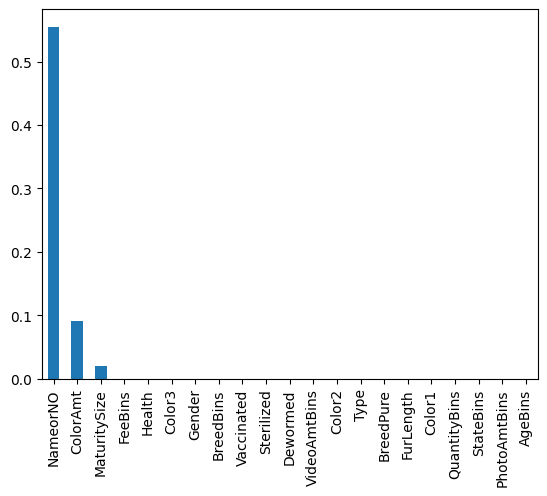

In [69]:
# Test which columns are significant

from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder

# Split into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Ordinal encoding assumes that the data is ordinal, which is not the case for most columns in this dataset
# However, this should be fine for the chi-squared test, which ignores the ordinal nature of the data
# The chi-squared test is used to determine if two categorical variables are independent
# If a column is independent of the target variable, it suggests that it is not useful for prediction

x_ordinal = x_train.copy()
oe = OrdinalEncoder()
x_ordinal = oe.fit_transform(x_ordinal)

chi_scores = chi2(x_ordinal, y_train)
p_values = pd.Series(chi_scores[1],index = x.columns)
p_values.sort_values(ascending = False , inplace = True)

# Plot the p-values
p_values.plot.bar()

# It seems like we can drop the NameorNO and ColorAmt columns

In [70]:
# Test independence between BreedPure and BreedBins
from scipy.stats import chi2_contingency

contingency = pd.crosstab(x_train['BreedBins'], x_train['BreedPure'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(chi2, p)

# Test independence between FurLength and BreedBins
contingency = pd.crosstab(x_train['BreedBins'], x_train['FurLength'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(chi2, p)

# The columns are not independent as ex_trainpected, especially since BreedPure is derived from the Breed

# Test independence between BreedPure and FurLength
contingency = pd.crosstab(x_train['FurLength'], x_train['BreedPure'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(chi2, p)

# Actually, the columns are independent! In this case, let's keep all of them.

7256.688658336328 0.0
4802.6120231857485 0.0
87.42699401226184 1.0362617441868428e-19


Index(['NameorNO', 'Color1', 'FeeBins', 'BreedPure', 'VideoAmtBins',
       'MaturitySize', 'Color3', 'ColorAmt', 'Gender', 'Color2', 'StateBins'],
      dtype='object')


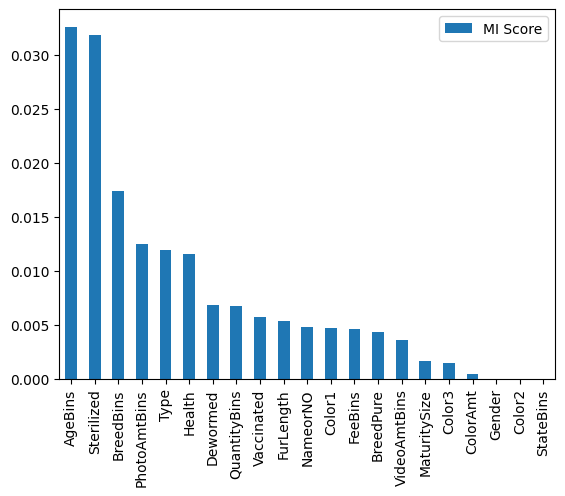

In [71]:
# Only two columns were dropped, let's see if we can reduce the number of columns by considering mutual information gain as well
# Jason Brownlee: "Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable."

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(x_ordinal, y_train)

# Create a DataFrame of the scores
mi_scores = pd.DataFrame(fs.scores_, index=x.columns, columns=['MI Score'])
mi_scores.sort_values(by='MI Score', ascending=False, inplace=True)

# Plot the scores
mi_scores.plot.bar()

# We can try eliminating columns with mutual information score less than 0.005
to_drop = mi_scores.index[mi_scores['MI Score'] < 0.005]
print(to_drop)

In [72]:
# Let's test the performances of feature selected datasets with logistic regression
# Linear regression is appropriate here because the AdoptionSpeed variable we're predicting
# is ordinal in nature
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# First, test with the entire dataset

# Hot encode the data because logistic regression assumes that the data is continuous
from sklearn.preprocessing import OneHotEncoder

x_hot_train = x_train.copy()
ohe = OneHotEncoder()
x_hot_train = ohe.fit_transform(x_hot_train)

x_hot_test = x_test.copy()
x_hot_test = ohe.transform(x_hot_test)

# Train the model
model = LinearRegression()
model.fit(x_hot_train, y_train)

# Make predictions
y_pred = model.predict(x_hot_test)
# Round the predictions to the nearest integer
y_pred = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.2750916972324108


In [73]:
# Now, test with the feature selected dataset from the chi-squared test
x_train_chi = x_train.drop(['NameorNO', 'ColorAmt'], axis=1)
x_test_chi = x_test.drop(['NameorNO', 'ColorAmt'], axis=1)

x_hot_train_chi = x_train_chi.copy()
x_hot_train_chi = ohe.fit_transform(x_hot_train_chi)

x_hot_test_chi = x_test_chi.copy()
x_hot_test_chi = ohe.transform(x_hot_test_chi)

# Train the model
model = LinearRegression()
model.fit(x_hot_train_chi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_chi)
# Round the predictions to the nearest integer
y_pred = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Very similar performance

0.2750916972324108


In [74]:
# Finally, test with the feature selected dataset from the mutual information gain test
x_train_mi = x_train.drop(to_drop, axis=1)
x_test_mi = x_test.drop(to_drop, axis=1)

x_hot_train_mi = x_train_mi.copy()
x_hot_train_mi = ohe.fit_transform(x_hot_train_mi)

x_hot_test_mi = x_test_mi.copy()
x_hot_test_mi = ohe.transform(x_hot_test_mi)

# Train the model
model = LinearRegression()
model.fit(x_hot_train_mi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_mi)
# Round the predictions to the nearest integer
y_pred = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# 0.7% worse than the model with all features - might as well keep all the features since dataset isn't too large

0.2720906968989663


In [75]:
# Linear regression seems to be performing quite poorly, let's try a different model
# We can try a decision tree model, which is appropriate for classification problems

from sklearn.tree import DecisionTreeClassifier

# Train the model
model = DecisionTreeClassifier()
model.fit(x_ordinal, y_train)

# Make predictions
x_ordinal_test = x_test.copy()
x_ordinal_test = oe.transform(x_ordinal_test)
y_pred = model.predict(x_ordinal_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# The decision tree model performs much better than the linear regression model (0.3221)

0.3211070356785595


In [76]:
# Try a random forest model
from sklearn.ensemble import RandomForestClassifier

# Train the model
model = RandomForestClassifier()
model.fit(x_ordinal, y_train)

# Make predictions
y_pred = model.predict(x_ordinal_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# The random forest model performs even better than the decision tree model (0.3881)

0.3907969323107703


In [77]:
# Try a gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier

# Train the model
model = GradientBoostingClassifier()
model.fit(x_ordinal, y_train)

# Make predictions
y_pred = model.predict(x_ordinal_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# The gradient boosting model performs the best so far (0.3914)

0.39179726575525176


In [97]:
# Hmm, since classification models seem to be performing well, let's try a logistic regression model too
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train, y_train)

# Make predictions
y_pred = model.predict(x_hot_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Turns out logistic regression performs even better! (0.3965)
# Perhaps the AdoptionSpeed variable acts more like a nominal variable 
# since bins are not linear?

0.39713237745915303


In [ ]:
# Also check if it makes sense to split the dataset into dogs (Type = 1) and cats (Type = 2)
# because the distributions of the target variable may be different for each type

mask = df['Type'] == 1
dogs = df.loc[mask, :]
cats = df.loc[~mask, :]
print(dogs.shape)
print(cats.shape)

(8132, 49)
(6861, 49)


In [95]:
x_dogs, y_dogs = process_df(dogs)

# Split into train and test sets
x_train_dogs, x_test_dogs, y_train_dogs, y_test_dogs = train_test_split(x_dogs, y_dogs, test_size=0.2, random_state=0)

# Hot encode the data
x_hot_train_dogs = x_train_dogs.copy()
x_hot_train_dogs = ohe.fit_transform(x_hot_train_dogs)

x_hot_test_dogs = x_test_dogs.copy()
x_hot_test_dogs = ohe.transform(x_hot_test_dogs)

# Fit the linear regression model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_dogs, y_train_dogs)

# Test the performance
y_pred_dogs = model.predict(x_hot_test_dogs)
y_pred_dogs = np.round(y_pred_dogs)

accuracy_dogs = accuracy_score(y_test_dogs, y_pred_dogs)
print(accuracy_dogs)

# Accuracy is slightly better!

0.4074984634296251


In [96]:
# Now, test with cats
x_cats, y_cats = process_df(cats)

# Split into train and test sets
x_train_cats, x_test_cats, y_train_cats, y_test_cats = train_test_split(x_cats, y_cats, test_size=0.2, random_state=0)

# Hot encode the data
x_hot_train_cats = x_train_cats.copy()
x_hot_train_cats = ohe.fit_transform(x_hot_train_cats)

x_hot_test_cats = x_test_cats.copy()
x_hot_test_cats = ohe.transform(x_hot_test_cats)

# Fit the linear regression model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_cats, y_train_cats)

# Test the performance
y_pred_cats = model.predict(x_hot_test_cats)
y_pred_cats = np.round(y_pred_cats)

accuracy_cats = accuracy_score(y_test_cats, y_pred_cats)
print(accuracy_cats)

# Oh, accuracy suffers for cats though
# Splitting into dogs and cats may not be a good idea

0.37509104151493083


In [102]:
# Test gradient boosting and logistic regression models with dropped columns from chi-squared test
x_train_chi = x_train.drop(['NameorNO', 'ColorAmt'], axis=1)
x_test_chi = x_test.drop(['NameorNO', 'ColorAmt'], axis=1)

x_ordinal_train_chi = x_train_chi.copy()
x_ordinal_train_chi = oe.fit_transform(x_ordinal_train_chi)

x_ordinal_test_chi = x_test_chi.copy()
x_ordinal_test_chi = oe.transform(x_ordinal_test_chi)

# Train gradient boosting model
model = GradientBoostingClassifier()
model.fit(x_ordinal_train_chi, y_train)

# Make predictions
y_pred = model.predict(x_ordinal_test_chi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy for gradient boosting model: {accuracy}")

# Train logistic regression model
x_hot_train_chi = x_train_chi.copy()
x_hot_train_chi = ohe.fit_transform(x_hot_train_chi)

x_hot_test_chi = x_test_chi.copy()
x_hot_test_chi = ohe.transform(x_hot_test_chi)

model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_chi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_chi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy for logistic regression model: {accuracy}")

# Gradient boosting: 0.3914 (all features), 0.3898 (chi-squared test) 
# Logistic regression: 0.3965 (all features), 0.3975 (chi-squared test)

accuracy for gradient boosting model: 0.38979659886628876
accuracy for logistic regression model: 0.3974658219406469


In [103]:
# Test gradient boosting and logistic regression models with dropped columns from mutual information gain test
x_train_mi = x_train.drop(to_drop, axis=1)
x_test_mi = x_test.drop(to_drop, axis=1)

x_ordinal_train_mi = x_train_mi.copy()
x_ordinal_train_mi = oe.fit_transform(x_ordinal_train_mi)

x_ordinal_test_mi = x_test_mi.copy()
x_ordinal_test_mi = oe.transform(x_ordinal_test_mi)

# Train gradient boosting model
model = GradientBoostingClassifier()
model.fit(x_ordinal_train_mi, y_train)

# Make predictions
y_pred = model.predict(x_ordinal_test_mi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy for gradient boosting model: {accuracy}")

# Train logistic regression model
x_hot_train_mi = x_train_mi.copy()
x_hot_train_mi = ohe.fit_transform(x_hot_train_mi)

x_hot_test_mi = x_test_mi.copy()
x_hot_test_mi = ohe.transform(x_hot_test_mi)

model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_mi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_mi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy for logistic regression model: {accuracy}")

# Gradient boosting: 0.3914 (all features), 0.3898 (chi-squared test), 0.3871 (mutual information gain test)
# Logistic regression: 0.3965 (all features), 0.3975 (chi-squared test), 0.3868 (mutual information gain test)
# The logistic regression model with the chi-squared test feature selected dataset performs the best

accuracy for gradient boosting model: 0.3871290430143381
accuracy for logistic regression model: 0.3867955985328443


In [104]:
# Now let's move on with processing the text data!
text_train_x = df[['Name','Description']].iloc[x_train.index]
text_test_x = df[['Name','Description']].iloc[x_test.index]

print(text_train_x.head())

                    Name                                        Description
4977              Vanila  / Adorable local mix Persian kitten looking fo...
14176          Cliff-ord  Clifford and his 3 siblings need a home. Mothe...
2137   â¥ ..Teddy.. â¥  Introducing Teddy! ♥ Adult male Shih Tzu, 1+ y...
14768               Kiss  Poor Kiss was rescued off a road while he/she ...
14437                Sam  Sam has lots of love to give! He even has a lo...


In [105]:
# The text contains a lot of special characters and some typos that we need to clean up
def clean_text(text):
    text = text.str.lower()
    text = text.str.replace(r'[^a-z\s0-9]', '')
    text = text.str.replace(r'\s+', ' ')
    return text

text_train_x['Name'] = clean_text(text_train_x['Name'])
text_train_x['Description'] = clean_text(text_train_x['Description'])

print(text_train_x.head())

text_test_x['Name'] = clean_text(text_test_x['Name'])
text_test_x['Description'] = clean_text(text_test_x['Description'])

                    Name                                        Description
4977              vanila  / adorable local mix persian kitten looking fo...
14176          cliff-ord  clifford and his 3 siblings need a home. mothe...
2137   â¥ ..teddy.. â¥  introducing teddy! ♥ adult male shih tzu, 1+ y...
14768               kiss  poor kiss was rescued off a road while he/she ...
14437                sam  sam has lots of love to give! he even has a lo...


In [114]:
from spellchecker import SpellChecker
spell = SpellChecker()

# Find misspelled words in train set
misspelled = set()
typos_lengths = []  # List to store the lengths of typos

for index, row in text_train_x.iterrows():
    if pd.notnull(row['Description']):
        words = row['Description'].split()
        typos = spell.unknown(words)
        misspelled = misspelled.union(typos)
        # The number of typos may be a factor in the adoption speed as well, so we may want to create a new feature
        typos_lengths.append(len(typos))
    else:
        typos_lengths.append(0)  # Append 0 if the description is null

# Create a new column 'Typos' in the DataFrame
text_train_x['Typos'] = typos_lengths

print(misspelled)
print(len(misspelled))
# Quite a number of typos!

{'too!', 'pasar.', 'rescues,', 'ragdoll', 'kedah.', 'fax:', 'kidney.', 'lassie,', 'stress.', 'car!', 'script.', '1female(black).', 'girl....area', 'along..any', '8"(h)],', 'days!', 'sleeping.', 'feet/lap/shoulders.', 'mundar', 'fast-', 'neighbourhood.we', '(ie', 'friend".', 'information!', 'them).', 'smpai', 'selatan.(self-collect)', 'face,', 'rat!', 'is--', 'living.', 'pet....please', 'found,', 'kwin', 'choices.', 'jolly,', 'active/young', '6pm.', 'thanks.!', 'mork', 'doggie.....he', "'hump'", 'that"s', 'not-too-bad', 'libby', 'mah~~).', 'balls...very', 'nutrients,', 'died)', 'persion', 'social.', 'dachsun', '"fish"', '4)在约定好之后，我能够登门看看狗狗', 'betul....skang', '(non-negotiable)', 'e-mails', 'good).', 'mom...she', 'area..', 'juu', 'sylvester,', 'emmet.', 'girl(brown', 'enquiries,pls', 'guna', '***', 'cny!!', 'neighbourhood', 'world.their', 'chance?', 'yup,', 'softer.', 'exceptions.', 'split-faced', '2.always', 'here,&', 'tan).', 'mouth,', 'hhaha...', 'me...after', 'home.anyone', 'growth.'

In [116]:
text_train_x.head()

,Name,Description,Typos
4977,vanila,/ adorable local mix persian kitten looking fo...,23
14176,cliff-ord,clifford and his 3 siblings need a home. mothe...,9
2137,â¥ ..teddy.. â¥,"introducing teddy! ♥ adult male shih tzu, 1+ y...",37
14768,kiss,poor kiss was rescued off a road while he/she ...,5
14437,sam,sam has lots of love to give! he even has a lo...,19


In [118]:
# Add Typos column to test set

# Find misspelled words in test set
typos_lengths = []

for index, row in text_test_x.iterrows():
    if pd.notnull(row['Description']):
        words = row['Description'].split()
        typos = spell.unknown(words)
        # The number of typos may be a factor in the adoption speed as well, so we may want to create a new feature
        typos_lengths.append(len(typos))
    else:
        typos_lengths.append(0)  # Append 0 if the description is null

# Create a new column 'Typos' in the DataFrame
text_test_x['Typos'] = typos_lengths

text_test_x.head()

,Name,Description,Typos
14361,3 little kittens,they say cats have 9 lives. but really these l...,8
12761,rory,rory is now ready for adoption. please share. ...,15
10031,@~smoky~@,"very active n playful with the kids, never bit...",11
7798,no name,3 kittens available for adoption. one mixed co...,12
6239,minnie,this minnie. she is very quiet and pampered pu...,6


In [ ]:
# Correct misspelled words with TextBlob
'''
from textblob import TextBlob

def correct_spelling(text):
    if pd.isnull(text):
        return text
    tb = TextBlob(text)
    return str(tb.correct())

text_train_x['Description'] = text_train_x['Description'].apply(correct_spelling)
text_test_x['Description'] = text_test_x['Description'].apply(correct_spelling)

# Test number of misspelled words again
misspelled = set()
for row in text_train_x['Description']:
    if pd.notnull(row):
        words = row.split()
        misspelled = misspelled.union(spell.unknown(words))

print(misspelled)
print(len(misspelled))

# Write the new data to a csv file
text_train_x.to_csv('text_train_x.csv', index=False)
text_test_x.to_csv('text_test_x.csv', index=False)
'''

# Number of identified typos reduced from 13005 to 6178
# Here, TextBlob took an extremely long time, about 6 hours...
# I have commented out the cell and saved the outputs in a text file instead
# Another solution to consider is symspellpy, which claims to six orders of magnitude faster

In [119]:
from textblob import TextBlob

def correct_spelling(text):
    if pd.isnull(text):
        return text
    tb = TextBlob(text)
    return str(tb.correct())

text_test_x['Description'] = text_test_x['Description'].apply(correct_spelling)

text_test_x.to_csv('text_test_x.csv', index=False)

In [124]:
# Load the data
text_train_x = pd.read_csv('text_train_x.csv')
text_test_x = pd.read_csv('text_test_x.csv')
# Target variable y_train and y_test are already defined

# Investigate length of sequences
print(text_train_x['Description'].str.split().str.len().describe())
print(text_test_x['Description'].str.split().str.len().describe())

# Maximum length is 1226 but most sequences are less than 80 words, let's cut off at 1000 words
# At this point, I decided to omit the name column because it would likely add a lot of irrelevant 
# vocabulary to the embedding model

count    11970.000000
mean        61.764327
std         67.056145
min          0.000000
25%         21.000000
50%         44.000000
75%         80.000000
max       1226.000000
Name: Description, dtype: float64
count    2997.000000
mean       64.028028
std        72.888931
min         1.000000
25%        21.000000
50%        43.000000
75%        81.000000
max      1095.000000
Name: Description, dtype: float64


In [132]:
# Further split train set into train and validation sets
x_train_text, x_val_text, y_train_text, y_val_text = train_test_split(text_train_x, y_train, test_size=0.2, random_state=0)

In [ ]:
# Create a neural network - reference: https://www.tensorflow.org/tutorials/keras/text_classification

In [133]:
# Create text vectorization layer
from tensorflow.keras.layers import TextVectorization

max_features = 10000
sequence_length = 1000

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Adapt the vectorization layer to the training text
text_train = x_train_text['Description']
# Convert all values to strings
text_train = text_train.astype(str)
vectorize_layer.adapt(text_train)

In [135]:
# Apply the vectorization layer to the training, validation and test sets
x_train_text = vectorize_layer(x_train_text['Description'].astype(str))
x_val_text = vectorize_layer(x_val_text['Description'].astype(str))
x_test_text = vectorize_layer(text_test_x['Description'].astype(str))

In [ ]:
# Train a neural network with the text data
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Input(shape=(sequence_length,)),
    Embedding(max_features, 64, input_length=sequence_length),
    LSTM(64, return_sequences=True),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(x_train_text, y_train_text, epochs=epochs, validation_data=(x_val_text, y_val_text))

# I stopped the model early because val_loss was increasing while loss was decreasing,
# which is a sign of overfitting

In [145]:
# Let's try fitting the model with a lower learning rate, and stopping early
# with the EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping


callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', # Because there are 5 labels and they seem to behave like nominal variables
              metrics=['accuracy'])
history = model.fit(x_train_text, y_train_text, epochs=epochs, validation_data=(x_val_text, y_val_text), callbacks=[callback])

Epoch 1/10
300/300 [==============================] - 254s 828ms/step - loss: 0.5366 - accuracy: 0.7891 - val_loss: 2.4764 - val_accuracy: 0.3576
Epoch 2/10
300/300 [==============================] - 257s 858ms/step - loss: 0.4893 - accuracy: 0.8065 - val_loss: 2.6648 - val_accuracy: 0.3547
Epoch 3/10
300/300 [==============================] - 270s 900ms/step - loss: 0.4585 - accuracy: 0.8177 - val_loss: 2.9696 - val_accuracy: 0.3447
Epoch 4/10
300/300 [==============================] - 248s 827ms/step - loss: 0.4318 - accuracy: 0.8268 - val_loss: 3.1004 - val_accuracy: 0.3422


In [146]:
# Model is still overfitting quite drastically...
# Let's try adding a dropout layer and using L2 regularization

from keras.regularizers import l2
from keras.layers import Dropout

model = Sequential([
    Input(shape=(sequence_length,)),
    Embedding(max_features, 64, input_length=sequence_length),
    LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train_text, y_train_text, epochs=epochs, validation_data=(x_val_text, y_val_text), callbacks=[callback])

# Paused the cell due to slow learning

Epoch 1/10
300/300 [==============================] - 528s 2s/step - loss: 1.7279 - accuracy: 0.2613 - val_loss: 1.4858 - val_accuracy: 0.2964
Epoch 2/10
300/300 [==============================] - 513s 2s/step - loss: 1.5067 - accuracy: 0.2681 - val_loss: 1.4662 - val_accuracy: 0.2964
Epoch 3/10
300/300 [==============================] - 573s 2s/step - loss: 1.4973 - accuracy: 0.2647 - val_loss: 1.4615 - val_accuracy: 0.2964
Epoch 4/10
300/300 [==============================] - 563s 2s/step - loss: 1.4942 - accuracy: 0.2719 - val_loss: 1.4615 - val_accuracy: 0.2964
Epoch 5/10
245/300 [=======================>......] - ETA: 1:32 - loss: 1.4936 - accuracy: 0.2685

KeyboardInterrupt: 

In [147]:
# A little too good at preventing overfitting, let's relax the dropout rate and L2 regularization
model = Sequential([
    Input(shape=(sequence_length,)),
    Embedding(max_features, 64, input_length=sequence_length),
    LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0002), # Slightly higher learning rate
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train_text, y_train_text, epochs=epochs, validation_data=(x_val_text, y_val_text), callbacks=[callback])

Epoch 1/10
300/300 [==============================] - 561s 2s/step - loss: 1.5379 - accuracy: 0.2656 - val_loss: 1.4768 - val_accuracy: 0.2935
Epoch 2/10
300/300 [==============================] - 540s 2s/step - loss: 1.4923 - accuracy: 0.2871 - val_loss: 1.4437 - val_accuracy: 0.3460
Epoch 3/10
300/300 [==============================] - 517s 2s/step - loss: 1.4471 - accuracy: 0.3566 - val_loss: 1.4243 - val_accuracy: 0.3489
Epoch 4/10
300/300 [==============================] - 519s 2s/step - loss: 1.3857 - accuracy: 0.3996 - val_loss: 1.4250 - val_accuracy: 0.3685
Epoch 5/10
300/300 [==============================] - 543s 2s/step - loss: 1.3398 - accuracy: 0.4252 - val_loss: 1.4432 - val_accuracy: 0.3652
Epoch 6/10
300/300 [==============================] - 545s 2s/step - loss: 1.2828 - accuracy: 0.4667 - val_loss: 1.4808 - val_accuracy: 0.3660


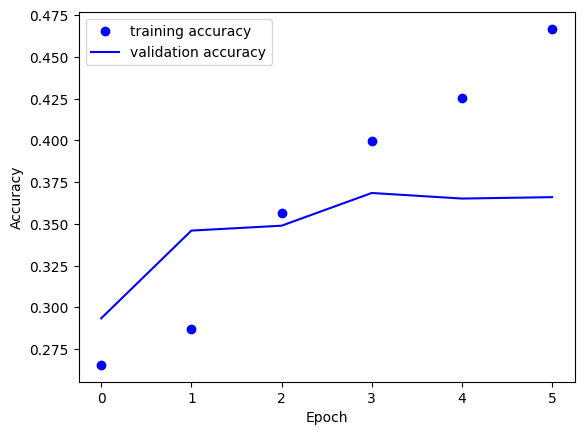

In [150]:
# The results are pretty good here with a validation accuracy of 0.3660!
# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'], 'bo', label='training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [151]:

# Let's try a different model - a convolutional neural network
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential([
    Input(shape=(sequence_length,)),
    Embedding(max_features, 64, input_length=sequence_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x_train_text, y_train_text, epochs=epochs, validation_data=(x_val_text, y_val_text), callbacks=[callback])

Epoch 1/10
300/300 [==============================] - 67s 213ms/step - loss: 1.5230 - accuracy: 0.2724 - val_loss: 1.4504 - val_accuracy: 0.2989
Epoch 2/10
300/300 [==============================] - 60s 201ms/step - loss: 1.4631 - accuracy: 0.3095 - val_loss: 1.4449 - val_accuracy: 0.2964
Epoch 3/10
300/300 [==============================] - 56s 185ms/step - loss: 1.4534 - accuracy: 0.3421 - val_loss: 1.4383 - val_accuracy: 0.3168
Epoch 4/10
300/300 [==============================] - 52s 172ms/step - loss: 1.4407 - accuracy: 0.3754 - val_loss: 1.4321 - val_accuracy: 0.3397
Epoch 5/10
300/300 [==============================] - 71s 237ms/step - loss: 1.4221 - accuracy: 0.3925 - val_loss: 1.4239 - val_accuracy: 0.3497
Epoch 6/10
300/300 [==============================] - 66s 221ms/step - loss: 1.3985 - accuracy: 0.4134 - val_loss: 1.4155 - val_accuracy: 0.3593
Epoch 7/10
300/300 [==============================] - 60s 198ms/step - loss: 1.3677 - accuracy: 0.4331 - val_loss: 1.4049 - val_ac

In [152]:
# The CNN seems to be doing well, and the validation loss is still decreasing at the end of the 10th epoch
# Let's continue training for a few more epochs

history = model.fit(x_train_text, y_train_text, epochs=epochs, validation_data=(x_val_text, y_val_text), callbacks=[callback])


Epoch 1/10
300/300 [==============================] - 50s 167ms/step - loss: 1.1717 - accuracy: 0.6095 - val_loss: 1.3745 - val_accuracy: 0.3777
Epoch 2/10
300/300 [==============================] - 59s 198ms/step - loss: 1.1066 - accuracy: 0.6685 - val_loss: 1.3691 - val_accuracy: 0.3856
Epoch 3/10
300/300 [==============================] - 65s 215ms/step - loss: 1.0384 - accuracy: 0.7093 - val_loss: 1.3670 - val_accuracy: 0.3877
Epoch 4/10
300/300 [==============================] - 57s 189ms/step - loss: 0.9691 - accuracy: 0.7504 - val_loss: 1.3690 - val_accuracy: 0.3914
Epoch 5/10
300/300 [==============================] - 55s 184ms/step - loss: 0.8989 - accuracy: 0.7825 - val_loss: 1.3796 - val_accuracy: 0.3822
Epoch 6/10
300/300 [==============================] - 54s 179ms/step - loss: 0.8278 - accuracy: 0.8048 - val_loss: 1.3957 - val_accuracy: 0.3789


In [153]:
# val_accuracy: 0.3789
# Let's save the model
model.save('text_model.h5')

c:\Users\user\github-projects\aichallenge\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [159]:
# Now, we can use the model to create a new feature for the original dataset
# This feature will be the predicted AdoptionSpeed for each pet based on the text data
# Let's attach this feature and the typos feature to the original dataset

# Load the model
from tensorflow.keras.models import load_model
model = load_model('text_model.h5')

# In the interest of time, I didn't want to redo the spellcheck, so I'll reprocess the 
# spellchecked text data. Will handle this properly in the model pipeline!
text_train_x = pd.read_csv('text_train_x.csv')
text_test_x = pd.read_csv('text_test_x.csv')

def count_typos(df):
    typos_lengths = []
    for index, row in df.iterrows():
        if pd.notnull(row['Description']):
            words = row['Description'].split()
            typos = spell.unknown(words)
            typos_lengths.append(len(typos))
        else:
            typos_lengths.append(0)  # Append 0 if the description is null
    return typos_lengths

x_train['Typos'] = count_typos(text_train_x)
x_test['Typos'] = count_typos(text_test_x)

def generate_predictions(df):
    # Apply the vectorization layer to the training, validation and test sets
    x_text = vectorize_layer(df['Description'].astype(str))
    return model.predict(x_text)

train_pred = generate_predictions(text_train_x)
test_pred = generate_predictions(text_test_x)

# Attach the predictions to the original dataset
x_train['TextPrediction'] = np.argmax(train_pred, axis=1)
x_train['TextPrediction'] = x_train['TextPrediction'].astype('int64')
x_test['TextPrediction'] = np.argmax(test_pred, axis=1)
x_test['TextPrediction'] = x_test['TextPrediction'].astype('int64')

x_test.head()


94/94 [==============================] - 3s 31ms/step


,Type,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,...,BreedBins,StateBins,VideoAmtBins,PhotoAmtBins,QuantityBins,BreedPure,ColorAmt,NameorNO,Typos,TextPrediction
14361,2,3,1,6,0,1,1,2,2,2,...,Others,41326,0,4,2,Y,2,Y,8,2
12761,1,1,7,0,0,2,2,1,1,2,...,307,41326,0,3,1,N,1,Y,14,2
10031,2,2,2,5,0,2,1,2,2,2,...,292,41401,0,5,1,Y,2,Y,10,2
7798,2,3,2,7,0,2,1,2,1,2,...,266,41401,0,>=6,3,Y,2,N,12,2
6239,1,2,1,2,0,2,1,2,2,2,...,307,41326,0,5,1,N,2,Y,6,4


In [169]:
x_train.head()

,Type,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,...,StateBins,VideoAmtBins,PhotoAmtBins,QuantityBins,BreedPure,ColorAmt,NameorNO,TextPrediction,Typos,TyposBins
4977,2,1,5,0,0,2,3,2,1,2,...,41326,0,>=6,1,N,1,Y,1,2,2
14176,1,1,3,5,0,2,1,2,2,2,...,41326,0,2,1,N,2,Y,2,1,1
2137,1,1,1,2,7,1,3,1,1,1,...,41326,0,4,1,Y,3,Y,1,7,2+
14768,2,2,3,7,0,1,2,2,2,2,...,41326,0,2,1,Y,2,Y,4,2,2
14437,1,1,2,7,0,2,1,2,1,2,...,41326,0,2,1,N,2,Y,4,4,2+


In [163]:
# Let's try fitting a logistic regression model with the new features

# First, we should bin the typos feature
# Investigate the distribution of the typos feature
x_train['Typos'].describe()

count    11994.000000
mean         1.844255
std          3.129319
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         59.000000
Name: Typos, dtype: float64

In [ ]:
# Most descriptions seem to have 0, 1 or 2 typos, so we can bin them into 0, 1, 2, and 2+
x_train['TyposBins'] = pd.cut(x_train['Typos'], bins=[-1, 0, 1, 2, np.inf], labels=['0', '1', '2', '2+'])  
x_test['TyposBins'] = pd.cut(x_test['Typos'], bins=[-1, 0, 1, 2, np.inf], labels=['0', '1', '2', '2+'])
x_train.drop('Typos', axis=1, inplace=True)
x_test.drop('Typos', axis=1, inplace=True)

In [174]:
# Hot encode the data
x_hot_train = x_train.copy()
x_hot_train = ohe.fit_transform(x_hot_train)

x_hot_test = x_test.copy()
x_hot_test = ohe.transform(x_hot_test)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train, y_train)

# Make predictions
y_pred = model.predict(x_hot_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

(11994, 100)
0.36845615205068355


In [175]:
# The accuracy is 0.3685, which is slightly worse than the model without the text data
# Let's check the distribution of the TextPrediction feature
x_train['TextPrediction'].value_counts()

TextPrediction
2    4320
4    3664
1    2263
3    1747
Name: count, dtype: int64

In [177]:
x_test['TextPrediction'].value_counts()
# The model never predicts 0, but the distribution is similar to the target variable

TextPrediction
2    1333
4     930
1     478
3     258
Name: count, dtype: int64

In [180]:
# Let's try a gradient boosting model

# Ordinal encode the data
x_ordinal_train = x_train.copy()
x_ordinal_train = oe.fit_transform(x_ordinal_train)

x_ordinal_test = x_test.copy()
x_ordinal_test = oe.transform(x_ordinal_test)

# Train the model
model = GradientBoostingClassifier()
model.fit(x_ordinal_train, y_train)

# Make predictions
y_pred = model.predict(x_ordinal_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Accuracy is 0.3678, which is again worse than the model without the text data,
# and the CNN alone!

0.3677892630876959


In [181]:
# Try dropping the typos feature
x_train = x_train.drop('TyposBins', axis=1)
x_test = x_test.drop('TyposBins', axis=1)

# Hot encode the data
x_hot_train = x_train.copy()
x_hot_train = ohe.fit_transform(x_hot_train)

x_hot_test = x_test.copy()
x_hot_test = ohe.transform(x_hot_test)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train, y_train)

# Make predictions
y_pred = model.predict(x_hot_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# The accuracy is 0.3685, which is the same as the model with the typos feature

0.36845615205068355


In [185]:
# Let's try taking the average of the text prediction and the model prediction

# Train logistic regression model without the text prediction feature
# x_train = x_train.drop('TextPrediction', axis=1)
# x_test = x_test.drop('TextPrediction', axis=1)

x_hot_train = x_train.copy()
x_hot_train = ohe.fit_transform(x_hot_train)

x_hot_test = x_test.copy()
x_hot_test = ohe.transform(x_hot_test)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train, y_train)

# Make predictions
y_pred_lr = model.predict(x_hot_test)
y_pred_cnn = np.argmax(test_pred, axis=1)

# Take the average of the predictions
y_pred = (y_pred_lr * 0.51 + y_pred_cnn * 0.49).round() # favour the logistic regression model in rounding scenarios since it has a higher accuracy

# Evaluate the model
lr_accuracy = accuracy_score(y_test, y_pred_lr)
cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
print(f"accuracy for logistic regression model: {lr_accuracy}")
print(f"accuracy for CNN model: {cnn_accuracy}")
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# The accuracy is still worse than either model alone

accuracy for logistic regression model: 0.39713237745915303
accuracy for CNN model: 0.36612204068022675
0.3601200400133378


In [195]:
# It seems the models are not complementary
# Another approach I wanted to try was to use LLMs to generate predictions from the descriptions
# Not sure if this might work, so I'll use the OpenAI API to do some really quick tests first.
# If it shows promise we may have to consider using a open source model and doing some fine-tuning

from openai import OpenAI
import os
os.environ['OPENAI_API_KEY'] = 'API KEY HERE'
client = OpenAI()

def generate_prediction(description):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are evaluating pet descriptions to predict how fast the pet would be adopted. For each description, only respond with a number from 1 to 5, with 1 being the fastest and 5 being the slowest."},
            {"role": "user", "content": description},
        ]
    )
    return response.choices[0].message.content

# Test the function
print(df['Description'][0], generate_prediction(df['Description'][0]))

# The function works!

Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care. 4


In [197]:
# Let's generate predictions for 100 descriptions and see if the predictions are consistent with the actual AdoptionSpeed

# Generate predictions for 100 descriptions
descriptions = df['Description'].iloc[:100]
predictions = []
for description in descriptions:
    if pd.isna(description):
        predictions.append(0)
    else:
        prediction = generate_prediction(description)
        if len(prediction) == 1:
            predictions.append(int(prediction) - 1)
        else:
            print(f"Prediction: {prediction} is not a number")
            predictions.append(0)

# Convert predictions to integers
predictions = [int(x) for x in predictions]

# Evaluate the predictions
accuracy = accuracy_score(df['AdoptionSpeed'].iloc[:100], predictions)


Prediction: I apologize for the oversight. Could you please provide me with the pet description so I can evaluate it for you? is not a number
Prediction: Please provide me with the first pet description to evaluate. is not a number


In [198]:
print(accuracy)

# The accuracy is 0.3, which is honestly not terrible given that the model has no information about the dataset
# or the exact nature of the target variable

# I suspect LLMs may have potential in generating new features (e.g. sentiment analysis, identifying strengths and weaknesses),
# but I will not pursue this further due to time constraints

0.3


In [199]:
# I don't really want to disregard the description field completely as I think it plays a decent role...
# Let's try making a new feature based on the length of the description

# Investigate the distribution of the length of the description
df['Description'].str.split().str.len().describe()

# We can bin them later based on these splits

count    14980.000000
mean        62.972363
std         69.329075
min          1.000000
25%         21.000000
50%         44.000000
75%         81.000000
max       1257.000000
Name: Description, dtype: float64

In [204]:
# Add the new feature to the dataset
x_train['DescriptionLength'] = text_train_x['Description'].str.split().str.len().fillna(0)
x_test['DescriptionLength'] = text_test_x['Description'].str.split().str.len().fillna(0)

# Bin the new feature
x_train['DescriptionLengthBins'] = pd.cut(x_train['DescriptionLength'], bins=[-1, 0, 22, 45, 82, np.inf], labels=['0', '1-21', '22-44', '45-81', '81+'])
x_test['DescriptionLengthBins'] = pd.cut(x_test['DescriptionLength'], bins=[-1, 0, 22, 45, 82, np.inf], labels=['0', '1-21', '22-44', '45-81', '81+'])
x_train.drop('DescriptionLength', axis=1, inplace=True)
x_test.drop('DescriptionLength', axis=1, inplace=True)

# Hot encode the data
x_hot_train = x_train.copy()
x_hot_train = ohe.fit_transform(x_hot_train)

x_hot_test = x_test.copy()
x_hot_test = ohe.transform(x_hot_test)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train, y_train)

# Make predictions
y_pred = model.predict(x_hot_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# 0.3971 - well, it's a slight improvement

0.39713237745915303
